In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cryptowatch as cw

In [2]:
Markets = ["kraken:btceur", "kraken:etheur"]
           #, "kraken:ltceur", "kraken:bateur", "kraken:eoseur", "kraken:waveseur"]
#   ["kraken:algoeur", "kraken:repeur", "kraken:bcheur",
#   "kraken:adaeur", "kraken:linkeur", "kraken:atomeur","kraken:dasheur", "kraken:daieur", "kraken:dogeur",
#   "kraken:etceur", "kraken:gnoeur", "kraken:icxeur", "kraken:lskeur", "kraken:mlneur", "kraken:xmreur", 
#   "kraken:nanoeur", "kraken:omgeur", "kraken:paxgeur", "kraken:qtumeur", "kraken:xrpeur", "kraken:sceur",
#   "kraken:xlmeur", "kraken:usdteur", "kraken:xtzeur", "kraken:trxeur", "kraken:usdceur", "kraken:waveseur", 
#   "kraken:zeceur" ] 

StartDate = '2018-01-01'
# EndDate = ''

CapitalRisk = 3000

In [3]:
def PullMarkets(MarketList):
    MarketDf = pd.DataFrame()
    
    for m in MarketList:
        try:
            CoinName = m.split(':')[1]
            candles = cw.markets.get(m, ohlc=True)
            # Convert to data-frame
            df = pd.DataFrame(candles.of_1d, columns=['Date', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'Volum', 'NA'])
            # Drop the last column
            df.drop(columns=['NA'], inplace=True)
            
            # Set close time to second
            df['Date'] = pd.to_datetime(df['Date'], unit='s')

            # Set close time as index
            df.set_index('Date', inplace=True)

            # Adjusting the data frame according the defined start
            df = df.loc[df.index >= pd.to_datetime(StartDate)]
            # df = df.loc[df.index >= pd.to_datetime(EndDate)]
            
            if MarketDf.empty:
                MarketDf = pd.DataFrame(index=df.index)
                MarketDf[CoinName] = df['ClosePrice']
            else:
                MarketDf = pd.concat([MarketDf, df['ClosePrice']], axis=1)
                MarketDf = MarketDf.rename(columns={'ClosePrice':CoinName})
            
        finally:
            time.sleep(0.5)
        
    return MarketDf

In [4]:
Portfolio = PullMarkets(Markets)
Portfolio

,btceur,etheur
Date,,
2018-01-01,11993.6,639.00
2018-01-02,11359.3,638.02
2018-01-03,12299.8,713.00
2018-01-04,12650.0,779.22
2018-01-05,12750.4,791.98
...,...,...
2021-07-19,26893.6,1600.80
2021-07-20,26116.5,1541.28
2021-07-21,25285.0,1515.76


In [5]:
# Mean
Portfolio.pct_change(1).mean()

btceur    0.001489
etheur    0.002216
dtype: float64

In [6]:
Portfolio.corr()

,btceur,etheur
btceur,1.000000,0.883792
etheur,0.883792,1.000000


In [7]:
# Logarithmic daily return
PortfolioLogDailyRet = np.log(Portfolio/Portfolio.shift(1))
PortfolioLogDailyRet.head()

,btceur,etheur
Date,,
2018-01-01,NaN,NaN
2018-01-02,-0.054336,-0.001535
2018-01-03,0.079546,0.111112
2018-01-04,0.028074,0.088812
2018-01-05,0.007905,0.016243


In [8]:
# Covariance of the log return
PortfolioLogDailyRet.cov()*365.25

,btceur,etheur
btceur,0.630547,0.676281
etheur,0.676281,1.080043


In [9]:
# To always get the same random number if replaying the portfolio
# np.random.seed(101)

NbPortfolios = 5000
AllWeights = np.zeros((NbPortfolios, len(PortfolioLogDailyRet.columns)))
ret_array = np.zeros(NbPortfolios)
vol_array = np.zeros(NbPortfolios)
sharpe_array = np.zeros(NbPortfolios)

# Random simulation of the portfolio
for ind in range(NbPortfolios):
    # Rand weights and normalization
    weights = np.array(np.random.random(len(Portfolio.columns)))
    weights = weights/np.sum(weights)

    # Save the weights here
    AllWeights[ind,:] = weights    

    # Expected Return
    ret_array[ind] = np.sum(PortfolioLogDailyRet.mean() * weights * 365.25)

    # Expected volatility
    vol_array[ind] = np.sqrt(np.dot(weights.T, np.dot(PortfolioLogDailyRet.cov() * 365.25, weights)))

    # Sharpe ratio
    sharpe_array[ind] = ret_array[ind]/vol_array[ind]

In [10]:
# Maximum sharpe ratio and location
print('Optimal Sharpe Ratio:')
print(sharpe_array.max())
# print(sharpe_array.argmax())
print ('\nOptimal weights:')
for optw in zip(Markets, AllWeights[sharpe_array.argmax()]):
    print(optw)

Optimal Sharpe Ratio:
0.2974472442910586

Optimal weights:
('kraken:btceur', 0.7770032943578715)
('kraken:etheur', 0.22299670564212848)


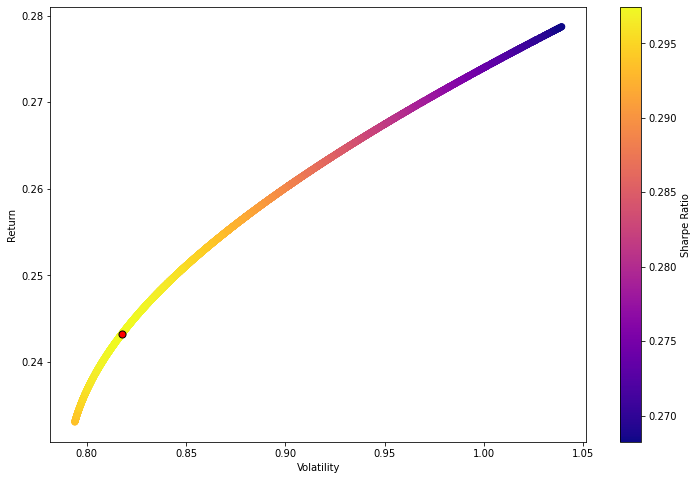

In [11]:
# Scatter plot for the portfolio
plt.figure(figsize=(12,8))
plt.scatter(vol_array, ret_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Scatter the best sharpe ratio
max_sr_ret = ret_array[sharpe_array.argmax()]
max_sr_vol = vol_array[sharpe_array.argmax()]

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

In [12]:
# Much better optimization
from scipy.optimize import minimize

# define a couple of functions
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(PortfolioLogDailyRet.mean() * weights) * 365.25
    vol = np.sqrt(np.dot(weights.T, np.dot(PortfolioLogDailyRet.cov()*365.25, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharp(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    # return 0 if the sum of the weights is one
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [13]:
cons = ({"type":"eq", "fun":check_sum})
bounds = tuple([(0,1)] * len(PortfolioLogDailyRet.columns))
init_guess = [1/len(PortfolioLogDailyRet.columns) for i in range(len(PortfolioLogDailyRet.columns))] 
opt_results = minimize(neg_sharp, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [14]:
print('\nOptimal weights:')
for optw in zip(Markets, opt_results.x):
    print(optw)

print('\nOptimal ret/vol/sr:')
print(get_ret_vol_sr(opt_results.x))


Optimal weights:
('kraken:btceur', 0.7768234497334964)
('kraken:etheur', 0.22317655026650357)

Optimal ret/vol/sr:
[0.24325167 0.81779769 0.29744724]


In [15]:
# Efficient frontier computation
# frontier_y = np.linspace(0, 1.5, 100)
# frontier_volatility = []

# for possible_return in frontier_y:
#     cons = ({"type":"eq", "fun":check_sum}, ({"type":"eq", "fun":lambda w: get_ret_vol_sr(w)[0] - possible_return}))
#     result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
#     frontier_volatility.append(result['fun'])

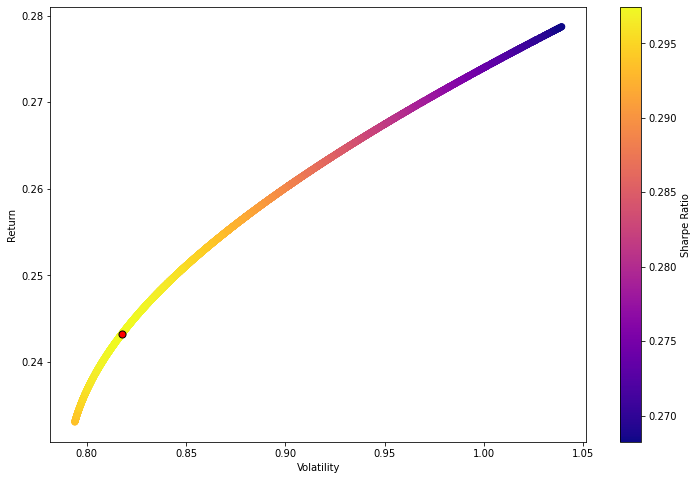

In [16]:
# Plotting the optimized results
# Scatter plot for the portfolio
plt.figure(figsize=(12,8))
plt.scatter(vol_array, ret_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Scatter the optimized sharpe ratio
max_sr_ret = get_ret_vol_sr(opt_results.x)[0]
max_sr_vol = get_ret_vol_sr(opt_results.x)[1]

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')
# plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)

In [17]:
PortfolioNormedReturn = Portfolio

# Benchmarking the portfolio with buy and hold
for name in Portfolio.columns:
    PortfolioNormedReturn[name] = Portfolio[name] / Portfolio.iloc[0][name]

# Quick fix
if 'Position' in PortfolioNormedReturn.columns:
    PortfolioNormedReturn = PortfolioNormedReturn.drop(columns=['Position'], axis=1)

# Sum the columns with the weights in Position column
PortfolioNormedReturn['Position'] = PortfolioNormedReturn[PortfolioNormedReturn.columns].mul(opt_results.x).sum(axis=1)

for col in PortfolioNormedReturn.columns:
    PortfolioNormedReturn[col] = PortfolioNormedReturn[col] * CapitalRisk

<AxesSubplot:xlabel='Date'>

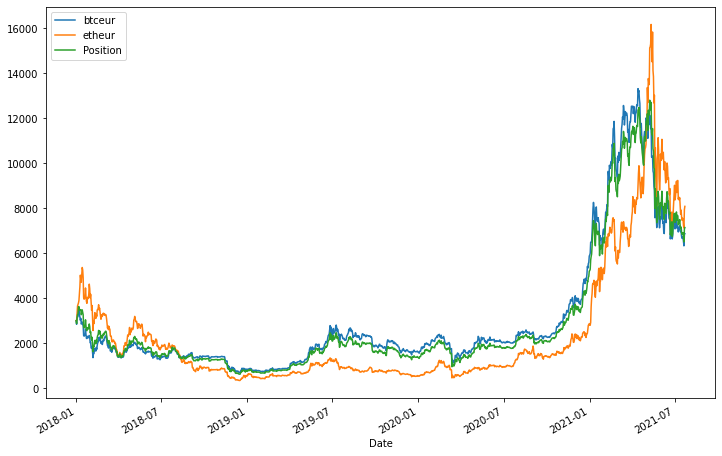

In [18]:
PortfolioNormedReturn.plot(figsize=(12,8))